## Import Necessary Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import json, os, sys
import tensorflow as tf
import scipy

# Keras and TensorFlow modules for building and training the model
from tensorflow.keras.utils import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import categorical_crossentropy

# For evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing import image

In [3]:
# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# Set the paths for training and validation data
train_data_dir = 'train'
validation_data_dir = 'test'

## Prepare Training Data

In [6]:
# Parameters
img_width, img_height = 48, 48
batch_size = 128

In [7]:
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [8]:
# Training generator
train_generator = train_datagen.flow_from_directory(
  train_data_dir,
  target_size=(img_width, img_height),
  batch_size=batch_size,
  class_mode='categorical',
  color_mode='grayscale',
)

train_generator.class_indices

Found 28709 images belonging to 7 classes.


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Prepare Validation Data

In [9]:
# Only rescale for validation data
val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Validation generator
validation_generator = val_datagen.flow_from_directory(
  validation_data_dir,
  target_size=(img_width, img_height),
  batch_size=batch_size,
  class_mode='categorical',
  color_mode='grayscale',
)

validation_generator.class_indices

Found 7178 images belonging to 7 classes.


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Build Model

In [11]:
# Define the model building function
def build_model():
    model = Sequential()

    # First block
    model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(48, 48, 1), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Second block
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Third block
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Fully connected layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [12]:
# Build the model
emotion_model = build_model()
emotion_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

## Build Early Stopping

In [13]:
# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

## Train Model

In [14]:
# Train the model
history = emotion_model.fit(
  train_generator,
  steps_per_epoch=train_generator.samples // batch_size,
  validation_data=validation_generator,
  validation_steps=validation_generator.samples // batch_size,
  epochs=500,
  callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/500
224/224 [==============================] - 228s 1s/step - loss: 1.9960 - accuracy: 0.2966 - val_loss: 1.9709 - val_accuracy: 0.1795 - lr: 0.0010
Epoch 2/500
224/224 [==============================] - 28s 123ms/step - loss: 1.5042 - accuracy: 0.4319 - val_loss: 2.4779 - val_accuracy: 0.3443 - lr: 0.0010
Epoch 3/500
224/224 [==============================] - 33s 147ms/step - loss: 1.3201 - accuracy: 0.5004 - val_loss: 1.2909 - val_accuracy: 0.5120 - lr: 0.0010
Epoch 4/500
224/224 [==============================] - 36s 159ms/step - loss: 1.2409 - accuracy: 0.5318 - val_loss: 1.1706 - val_accuracy: 0.5564 - lr: 0.0010
Epoch 5/500
224/224 [==============================] - 34s 152ms/step - loss: 1.1891 - accuracy: 0.5539 - val_loss: 1.2136 - val_accuracy: 0.5413 - lr: 0.0010
Epoch 6/500
224/224 [==============================] - 35s 154ms/step - loss: 1.1635 - accuracy: 0.5623 - val_loss: 1.2703 - val_accuracy: 0.5367 - lr: 0.0010
Epoch 7/500
224/224 [===========================

## Write model structure to JSON file

In [16]:
# save model structure in jason file
model_json = emotion_model.to_json()
with open("best_face_model.json", "w") as json_file:
    json_file.write(model_json)

## Model Evaluation

In [17]:
# Emotion dictionary
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

In [18]:
# Predict on validation data
predictions = emotion_model.predict(validation_generator)

57/57 [==============================] - 3s 53ms/step


-----------------------------------------------------------------
[[122   3 103 247 199 168 116]
 [ 13   0  16  33  22  15  12]
 [140   6 100 252 217 202 107]
 [249  12 197 427 391 289 209]
 [180   6 112 335 232 208 160]
 [149  17 118 307 257 240 159]
 [127   8  79 207 174 149  87]]


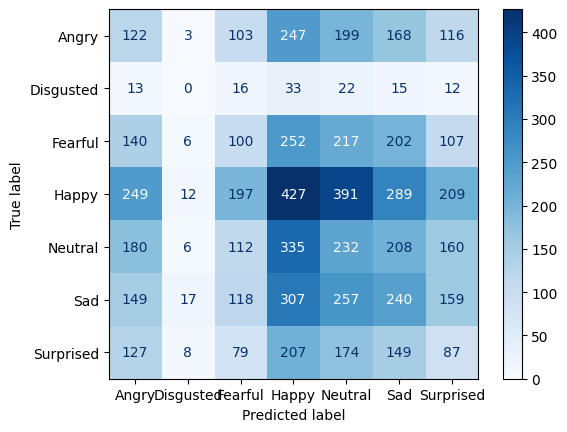

-----------------------------------------------------------------
              precision    recall  f1-score   support

       Angry       0.12      0.13      0.13       958
   Disgusted       0.00      0.00      0.00       111
     Fearful       0.14      0.10      0.11      1024
       Happy       0.24      0.24      0.24      1774
     Neutral       0.16      0.19      0.17      1233
         Sad       0.19      0.19      0.19      1247
   Surprised       0.10      0.10      0.10       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.17      0.17      7178



In [19]:
print("-----------------------------------------------------------------")
# Confusion matrix
c_matrix = confusion_matrix(validation_generator.classes, predictions.argmax(axis=1))
print(c_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels=emotion_dict.values())
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Classification report
print("-----------------------------------------------------------------")
print(classification_report(validation_generator.classes, predictions.argmax(axis=1), target_names=emotion_dict.values()))

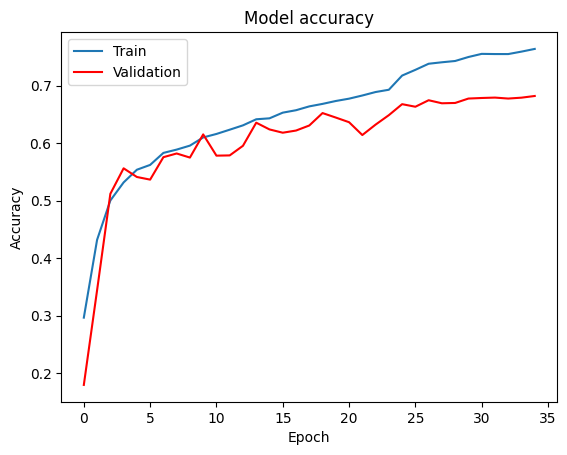

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], c='red')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

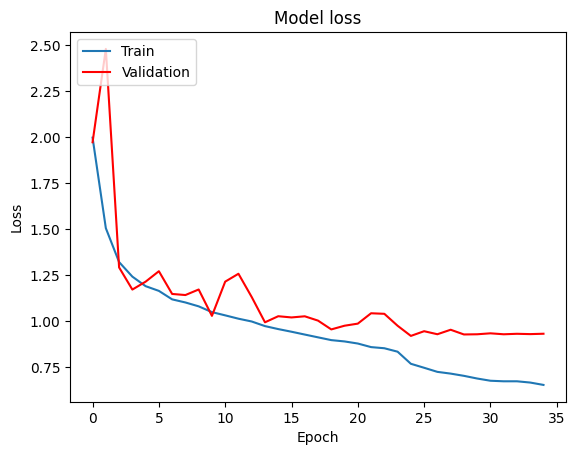

In [21]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], c='red')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Testing

In [23]:
# Function to load and prepare the image
def load_and_prepare_image(image_path, target_size=(48, 48)):
    try:
        img = load_img(image_path, target_size=target_size, color_mode='grayscale')
        img_array = img_to_array(img) / 255.0
        return np.expand_dims(img_array, axis=0)  # Add batch dimension
    except Exception as e:
        raise FileNotFoundError(f"Error loading image: {e}")

In [24]:
# Function to load the model from JSON file and weights
def load_model(json_path, weights_path):
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"JSON file {json_path} not found.")
    if not os.path.exists(weights_path):
        raise FileNotFoundError(f"Weights file {weights_path} not found.")
    
    with open(json_path, "r") as json_file:
        loaded_model_json = json_file.read()
    model = model_from_json(loaded_model_json)
    model.load_weights(weights_path)
    return model

In [25]:
# Function to predict the emotion from an image
def predict_emotion(model, image_array, emotion_dict):
    predictions = model.predict(image_array)
    predicted_class = np.argmax(predictions)
    return emotion_dict[predicted_class]

1/1 [==============================] - 0s 205ms/step
The image is of Disgusted


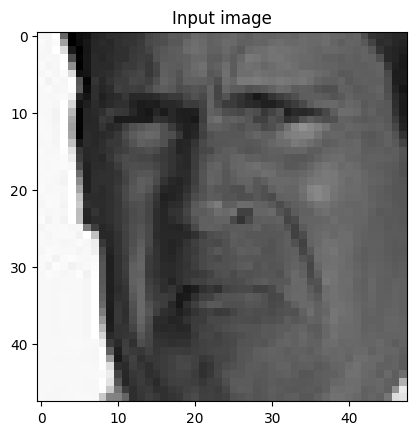

In [26]:
# Paths
image_path = "test/disgust/PrivateTest_807646.jpg"
json_path = "best_face_model.json"
weights_path = "best_model.h5"

# Emotion dictionary
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

# Load and prepare the image
input_arr = load_and_prepare_image(image_path)

# Load the model
trained_model = load_model(json_path, weights_path)

# Predict the emotion
predicted_emotion = predict_emotion(trained_model, input_arr, emotion_dict)
print(f"The image is of {predicted_emotion}")

# Display the image
plt.imshow(input_arr[0], cmap='gray')
plt.title("Input image")
plt.show()